In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import networkx as nx
from Dist_KL_UCB import Dist_KL_UCB
from KL_UCB import KL_UCB
from Dist_UCB1 import Dist_UCB1

n_runs = 5
T = 5000
N = 10
rwd_means = [.2, .3, .4, .5, .6]
kl_distributions = [sps.uniform(loc=rwd_means[i] - .1, scale=0.2) for i in range(len(rwd_means))]
distributions = [[sps.uniform(loc=rwd_means[i] - .1, scale=0.2) for i in range(len(rwd_means))] for n in range(N)]
sigmas = [1, .1, .01]

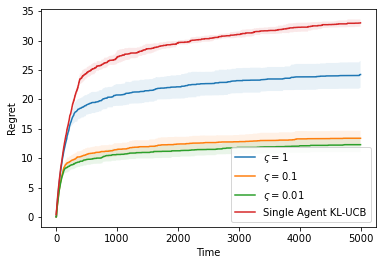

In [10]:
mean_regrets_dist_kl_ucb = np.zeros((n_runs, len(sigmas), T))
regrets_kl_ucb = np.zeros((n_runs, T))
for run in range(n_runs):
    G = nx.fast_gnp_random_graph(N, 0.5, directed=False)
    while not nx.is_connected(G):
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False)
    nodes = list(G.nodes)
    for i in nodes:
        G.add_edge(i,i) 
    for sig in range(len(sigmas)):
        distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas[sig])
        distkl.run()
        mean_regrets_dist_kl_ucb[run, sig, :] = np.mean(distkl.regrets, axis=0)

    kl = KL_UCB(T, kl_distributions)
    kl.run()
    regrets_kl_ucb[run, :] = kl.regret

time_axis = list(range(distkl.T))
mean_regrets_over_all_runs_dist_kl_ucb = np.mean(mean_regrets_dist_kl_ucb, axis=0)
mean_regrets_over_all_runs_kl_ucb = np.mean(regrets_kl_ucb, axis=0)
std_regrets_over_all_runs_dist_kl_ucb = np.std(mean_regrets_dist_kl_ucb, axis=0)
std_regrets_over_all_runs_kl_ucb = np.std(regrets_kl_ucb, axis=0)
for sig in range(len(sigmas)):
    plt.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig], label=r"$\varsigma=$" + str(sigmas[sig]))
    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig]-std_regrets_over_all_runs_dist_kl_ucb[sig], mean_regrets_over_all_runs_dist_kl_ucb[sig]+std_regrets_over_all_runs_dist_kl_ucb[sig],alpha=.1)
plt.plot(time_axis, mean_regrets_over_all_runs_kl_ucb, label="Single Agent KL-UCB")
plt.fill_between(time_axis, mean_regrets_over_all_runs_kl_ucb-std_regrets_over_all_runs_kl_ucb, mean_regrets_over_all_runs_kl_ucb+std_regrets_over_all_runs_kl_ucb, alpha=.1)
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()
plt.show()